In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import warnings as wrn
from typing import Optional, Tuple
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import time

wrn.filterwarnings("ignore")

model_name = "SamLowe/roberta-base-go_emotions"

config = AutoConfig.from_pretrained(model_name)
label_names = config.id2label

original_labels = [label_names[i] for i in range(len(label_names))]
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

df = pd.read_csv('../../data/test.csv')
new_labels = df.sentiment.unique().tolist()

print(original_labels)
print(new_labels)

/Users/user/anaconda3/envs/splore/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
['Happy', 'Surprised', 'Curious to dive deeper', 'Neutral', 'Sad', 'Fearful', 'Angry', 'Disgusted']


In [2]:
len(df)

11302

In [3]:
df.head(10)

,conversation_id,message,sentiment
0,5748,"Nice. My Zeppelin only goes0.160 mph, so I do...",Happy
1,3347,That is a lot! And 60 million of them are in t...,Surprised
2,7034,well i'm not sure if it was a government or a...,Surprised
3,3318,Hi! Are you into soccer or the FIFA world cup ...,Happy
4,283,They might need him,Curious to dive deeper
5,3033,Do you listen to much music?,Curious to dive deeper
6,4227,"ya I agree, I wonder if he would be mad that ...",Curious to dive deeper
7,3679,Thanks you too!,Happy
8,3868,oh yeah! I like doing that sometimes to set th...,Curious to dive deeper
9,1825,"Hahaa, Really? That's funny....I was surprise...",Surprised


In [4]:
import torch
import torch.nn.functional as F
import pandas as pd
import os
from typing import Optional, Tuple
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import time


def load_model(model_name: Optional[str]="SamLowe/roberta-base-go_emotions") -> Tuple[AutoModelForSequenceClassification, AutoTokenizer, AutoConfig]:
    """
        Load model from Hugging Face Transformers library with pretrained
        weights and tokenizer.
    """

    config = AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    return (model, tokenizer, config)

def get_labels(config: AutoConfig, file: Path) -> Tuple[list, list, dict]:
    """
        Get original labels and new labels from the model.
    """

    label_mapping = {
                        'curiosity': 'Curious to dive deeper',
                        'joy': 'Happy',
                        'neutral': 'Neutral',
                        'surprise': 'Surprised',
                        'disgust': 'Disgusted',
                        'sadness': 'Sad',
                        'fear': 'Fearful',
                        'anger': 'Angry'
                    }

    label_names = config.id2label

    original_labels = [label_names[i] for i in range(len(label_names))]

    df = pd.read_csv(file)
    new_labels = df.sentiment.unique().tolist()

    return (original_labels, new_labels, label_mapping)

def get_model_output(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    return logits

def map_labels(logits, original_labels, label_mapping):
    probs = F.softmax(logits, dim=-1)
    probs = probs.squeeze().detach().cpu().numpy()
    new_probs = {}
    for orig_label, new_label in label_mapping.items():
        if orig_label in original_labels:
            new_probs[new_label] = probs[original_labels.index(orig_label)]
    return new_probs

def evaluate(file: Path, label_mapping: dict, original_labels: list, output_file: str):
    """
    Evaluate the model on the test data.
    """
    df = pd.read_csv(file)
    y_true = df.sentiment.tolist()
    y_pred = []
    is_first_write = True

    for idx, text in enumerate(df.message.tolist()):
        hashmap = {}

        start_t = time.perf_counter()
        logits = get_model_output(text)
        probs = map_labels(logits, original_labels, label_mapping)
        pred = max(probs, key=probs.get)
        confidence = probs[pred]
        y_pred.append(pred)
        end_t = time.perf_counter()

        hashmap['id'] = idx
        hashmap['y_true'] = y_true[idx]
        hashmap['y_pred'] = pred
        hashmap['confidence'] = confidence
        hashmap['time'] = end_t - start_t

        # Create a DataFrame from the hashmap
        result_df = pd.DataFrame([hashmap])

        # Append to CSV
        if is_first_write:
            result_df.to_csv(output_file, mode='w', header=True, index=False)
            is_first_write = False
        else:
            result_df.to_csv(output_file, mode='a', header=False, index=False)




In [5]:
file = Path('../../data/test.csv')
model, tokenizer, config = load_model()
original_labels, new_labels, label_mapping = get_labels(config, file)

# Evaluate the model and save results
evaluate(file=file, label_mapping=label_mapping, original_labels=original_labels, output_file='../../result/roberta-sentiment-predictions.csv')

In [49]:
# model, tokenizer, config = load_model()
# original_labels, new_labels, label_mapping = get_labels(config, Path('../../data/test.csv'))
# text = "I am so happy today!"
# logits = get_model_output(text)
# res = map_labels(logits, original_labels, label_mapping)
# predicted_label = max(res, key=res.get)
# confidence = res[predicted_label]

# # Print the results
# print(f"Predicted sentiment: {predicted_label}")
# print(f"Confidence: {confidence:.4f}")

Predicted sentiment: Happy
Confidence: 0.9730
{'Curious to dive deeper': 0.00027628438, 'Happy': 0.97299194, 'Neutral': 0.0032016756, 'Surprised': 0.00027133513, 'Disgusted': 7.419249e-05, 'Sad': 0.00043982605, 'Fearful': 9.8953366e-05, 'Angry': 0.00035207652}


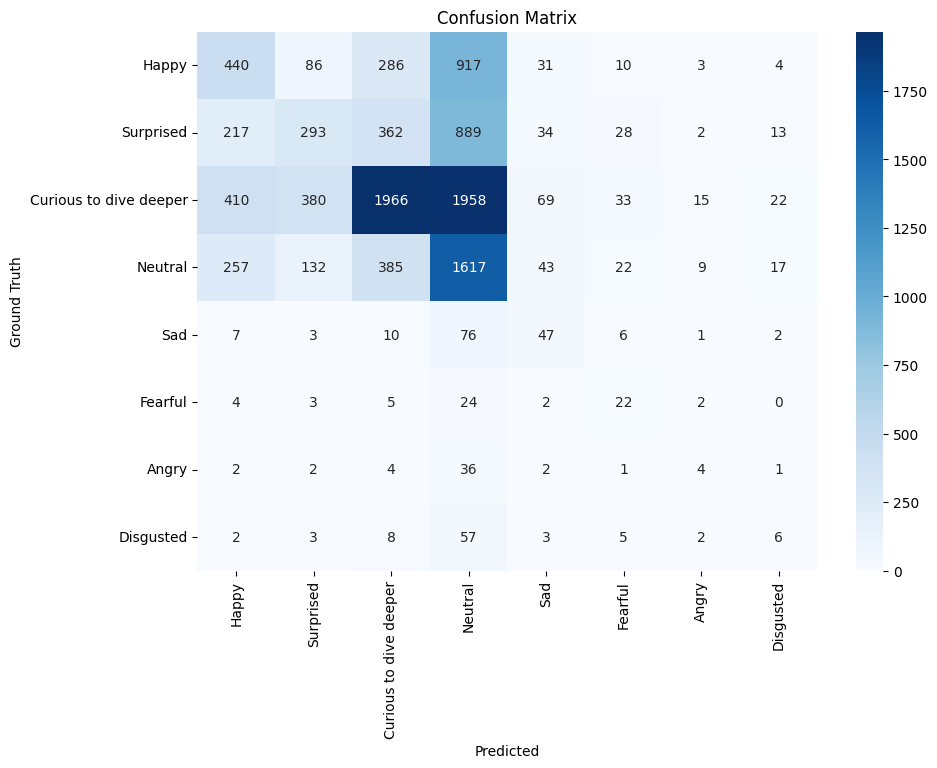

Classification Report:

                        precision    recall  f1-score   support

                 Happy       0.11      0.08      0.09        52
             Surprised       0.65      0.41      0.50      4853
Curious to dive deeper       0.09      0.07      0.08        86
               Neutral       0.17      0.35      0.23        62
                   Sad       0.33      0.25      0.28      1777
               Fearful       0.29      0.65      0.40      2482
                 Angry       0.20      0.31      0.25       152
             Disgusted       0.32      0.16      0.21      1838

              accuracy                           0.39     11302
             macro avg       0.27      0.28      0.26     11302
          weighted avg       0.45      0.39      0.39     11302



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


def load_and_evaluate(output_file='../../result/roberta-sentiment-predictions.csv') -> None:
    combined_df = pd.read_csv(output_file)
    y_true = combined_df['y_true']
    y_pred = combined_df['y_pred']
    y_labels = y_true.unique().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=y_labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=y_labels))


    report_dict = classification_report(y_true, y_pred, target_names=y_labels, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    report_df = pd.DataFrame(report_dict).transpose()

    cm_df = pd.DataFrame(cm, index=y_labels, columns=y_labels)
    
    with pd.ExcelWriter('../../result/roberta-sentiment-metrics.xlsx') as writer:
        report_df.to_excel(writer, sheet_name='Classification Report')
        cm_df.to_excel(writer, sheet_name='Confusion Matrix')

    
load_and_evaluate()